# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [1]:
#
# Add your code here
#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers

print("Number of GPU's available: ",len(tf.config.experimental.list_physical_devices('GPU')))
path=Path("/mnt/c/Users/Rwitobaan/Desktop/code/ML/train_val-20240224T201813Z-001/train_val/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
print(len(filenames))
print(filenames[:3])

2024-03-25 02:44:54.872194: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-25 02:44:55.043651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 02:44:55.043703: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 02:44:55.054889: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-25 02:44:55.116558: I tensorflow/core/platform/cpu_feature_guar

Number of GPU's available:  1
5000
['100_1_0_20170112215032192.jpg.chip.jpg', '100_1_2_20170112213615815.jpg.chip.jpg', '10_0_0_20161220222308131.jpg.chip.jpg']


2024-03-25 02:44:57.549110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 02:44:57.821291: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-25 02:44:57.821334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

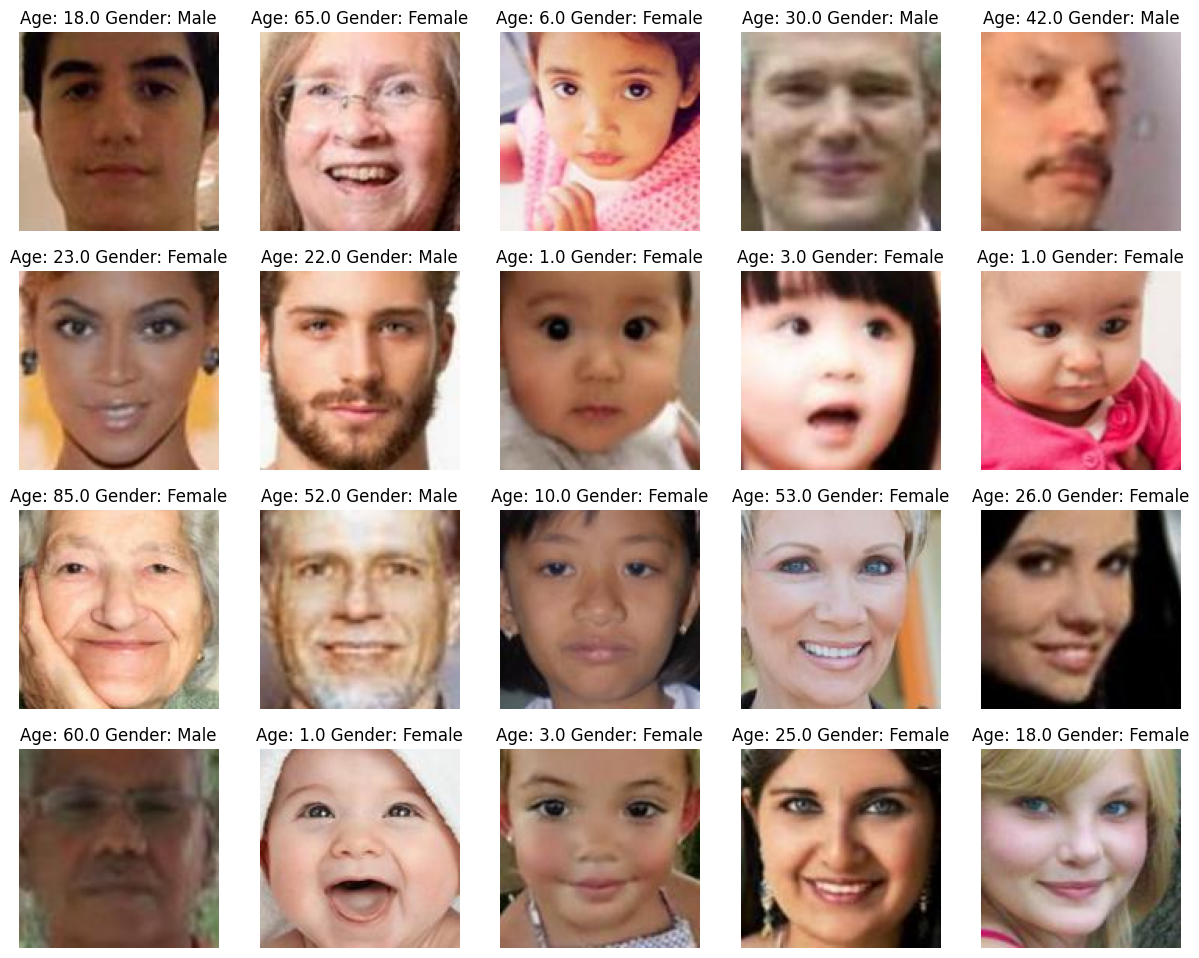

In [2]:
#
# Add your code here
#
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels
df.head()
gender_dict={0:'Male',1:'Female'}
df=df.astype({'age':'float32','gender':'int32'})

files=df.iloc[0:20]
plt.figure(figsize=(15,15))
for index,file,age,gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img=load_img("/mnt/c/Users/Rwitobaan/Desktop/code/ML/train_val-20240224T201813Z-001/train_val/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')



## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [21]:
#
# Add your code here
#

from keras.preprocessing.image import ImageDataGenerator

train, test= train_test_split(df, test_size=0.1, random_state=42)

train_1, valid= train_test_split(train, test_size=0.1, random_state=42)


## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [25]:
#
# Add your code here
#
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
    )
test_datagen = ImageDataGenerator(rescale=1./255)# no data augmentation for test or validation samples 



# this is a generator that will read pictures found in
# subfolers of training data, and indefinitely generate
# batches of training image data

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="/mnt/c/Users/Rwitobaan/Desktop/code/ML/train_val-20240224T201813Z-001/train_val/",
    x_col="image",
    y_col=["gender","age"],
    shuffle=True,
    target_size = (128,128),# all images will be resized to 150x150
    batch_size=8,
    seed=42,
    class_mode='multi_output',
    validate_filenames=True)# since we use binary_crossentropy loss, we need binary labels

# # this is a similar generator, for validation data
val_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory="/mnt/c/Users/Rwitobaan/Desktop/code/ML/train_val-20240224T201813Z-001/train_val/",
    x_col="image",
    y_col=["gender","age"],
    shuffle=False,
    target_size = (128,128),
    batch_size=8,
    seed=42,
    class_mode='multi_output',
    validate_filenames=True)


Found 4500 validated image filenames.
Found 500 validated image filenames.


## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 126, 126, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)           0         ['batch_normalization[0][0

2024-03-24 23:36:42.839902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 23:36:42.840022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 23:36:42.840041: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 23:36:43.039491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-24 23:36:43.039558: I external/local_xla/xla/stream_executor

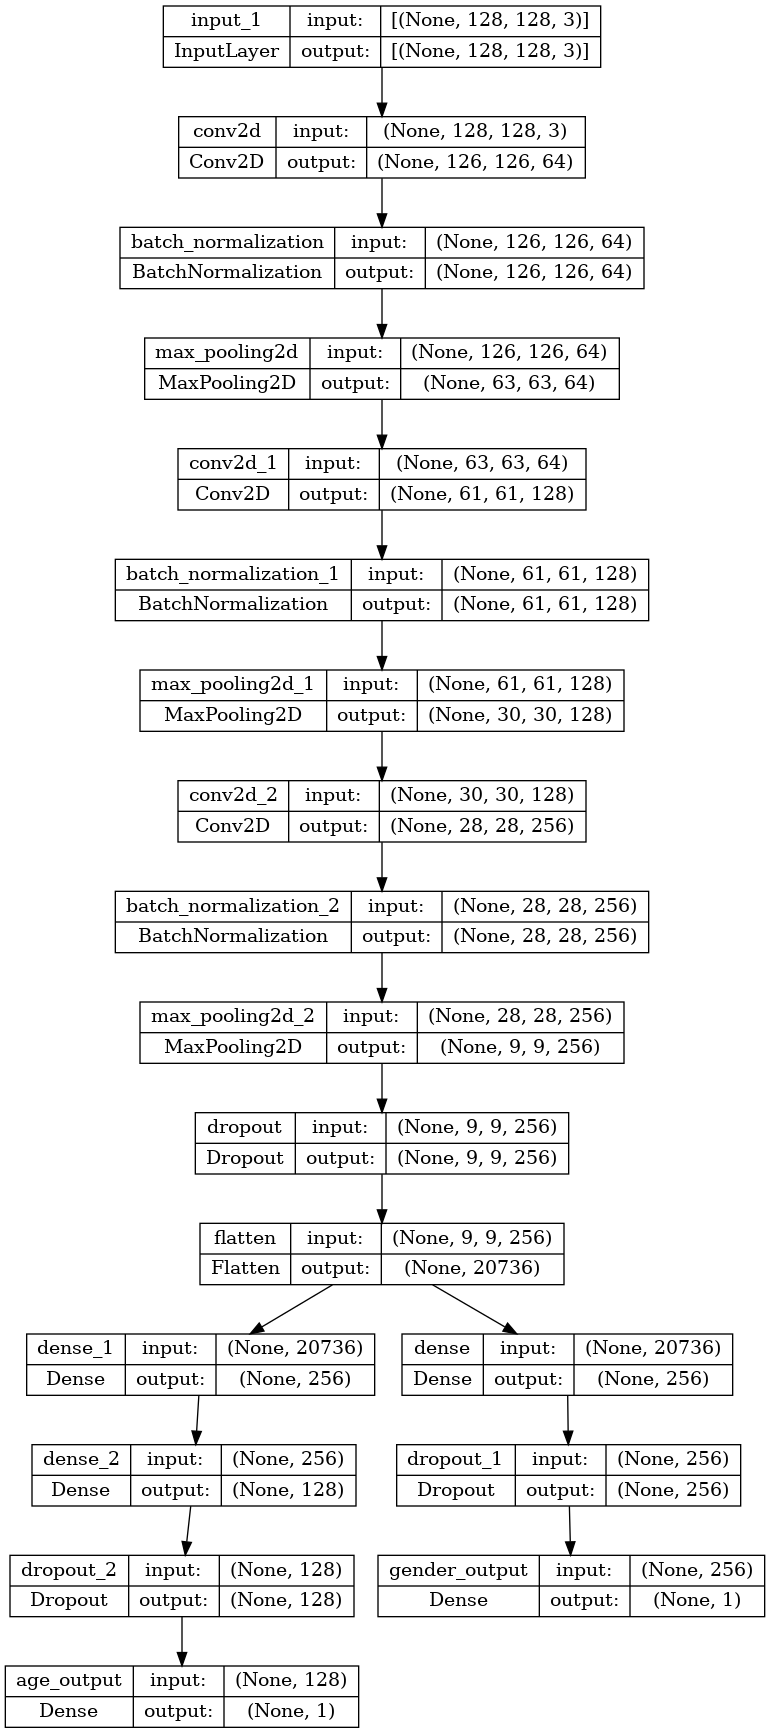

In [5]:
#
# Add your code here
#
early_stopping=EarlyStopping(
    patience=25,
    monitor='val_loss',
    restore_best_weights=True,
)

from keras.models import Sequential
modelA=Sequential()

input_size = (128,128,3)
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = BatchNormalization(axis = -1)(X)
X = MaxPooling2D((2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = BatchNormalization(axis = -1)(X)
X = MaxPooling2D((3, 3))(X)

X = Dropout(0.4)(X)
X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

modelA = Model(inputs=[inputs], outputs=[output_1,output_2])
modelA.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [6]:
#
# Add your code here
#
#loss=['gender_output':'binary_crossentropy','age_output':'mse'], optimizer='adam', metrics=['gender_output':'accuracy','age_output':'mae']#
modelA.compile(loss={'gender_output':'binary_crossentropy','age_output':'mse'}, optimizer='adam',metrics={'gender_output':'accuracy','age_output':'mae'})
modelA.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 126, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 126, 126, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 63, 63, 64)           0         ['batch_normalization[0][0

                                                                                                  
 dropout_2 (Dropout)         (None, 128)                  0         ['dense_2[0][0]']             
                                                                                                  
 gender_output (Dense)       (None, 1)                    257       ['dropout_1[0][0]']           
                                                                                                  
 age_output (Dense)          (None, 1)                    129       ['dropout_2[0][0]']           
                                                                                                  
Total params: 11023234 (42.05 MB)
Trainable params: 11022338 (42.05 MB)
Non-trainable params: 896 (3.50 KB)
__________________________________________________________________________________________________


In [7]:
#uncomment the line below to train model without augmented data 
# model_history = modelA.fit(x=x_train, y=[y_gender, y_age], batch_size = 8, epochs=100, 
#                            #validation_data=(x_test, [y_gender_test, y_age_test]),
#                            validation_split=0.1,
#                            callbacks=[early_stopping])

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
# # #STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#train the model with augmented data using train generator method
model_history = modelA.fit(train_generator, 
                           steps_per_epoch=STEP_SIZE_TRAIN, 
                           epochs=200,
                           validation_data=val_generator,
                           validation_steps=STEP_SIZE_VALID,
                           callbacks=[early_stopping])

modelA.save("/mnt/c/Users/Rwitobaan/Desktop/code/ML/"+"age_gender_A.h5")

Epoch 1/200


2024-03-24 19:28:02.065082: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-24 19:28:02.291372: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-03-24 19:28:04.020002: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7b9171f540 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-24 19:28:04.020052: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-24 19:28:04.025648: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1711308484.095656   27706 device_compiler.h:186] Compiled cluster using XLA!  T

506/506 [==============================] - 22s 34ms/step - loss: 465.1780 - gender_output_loss: 1.5915 - age_output_loss: 463.5868 - gender_output_accuracy: 0.6279 - age_output_mae: 16.4111 - val_loss: 581.5858 - val_gender_output_loss: 0.6508 - val_age_output_loss: 580.9351 - val_gender_output_accuracy: 0.6853 - val_age_output_mae: 19.4559
Epoch 2/200
506/506 [==============================] - 16s 31ms/step - loss: 354.2868 - gender_output_loss: 0.7097 - age_output_loss: 353.5769 - gender_output_accuracy: 0.6781 - age_output_mae: 14.3896 - val_loss: 374.2996 - val_gender_output_loss: 0.5516 - val_age_output_loss: 373.7480 - val_gender_output_accuracy: 0.7321 - val_age_output_mae: 14.0206
Epoch 3/200
506/506 [==============================] - 17s 33ms/step - loss: 327.0478 - gender_output_loss: 0.5893 - age_output_loss: 326.4586 - gender_output_accuracy: 0.7048 - age_output_mae: 13.7832 - val_loss: 320.6519 - val_gender_output_loss: 0.5345 - val_age_output_loss: 320.1174 - val_gender_o

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
x_test = []
for file in test.image:
    img = load_img("/mnt/c/Users/Rwitobaan/Desktop/code/ML/train_val-20240224T201813Z-001/train_val/"+file, color_mode="rgb")
    img = img.resize((128,128), Image.Resampling.LANCZOS)
    img = np.array(img)
    x_test.append(img)

x_test = np.array(x_test)

x_test = x_test.reshape(len(x_test), 128,128,3)

x_test = x_test/255
y_gender_test = np.array(test.gender)
y_age_test = np.array(test.age)
y_test=[y_gender_test,y_age_test]

In [24]:
accuracy=modelA.evaluate(x=x_test,y=[y_gender_test,y_age_test])

NameError: name 'modelA' is not defined

In [10]:
print(accuracy)

[72.87884521484375, 0.2716336250305176, 72.60720825195312, 0.871999979019165, 6.292941570281982]


## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


Minimum Validation Loss for Gender: 0.2993
Maximum Validation Accuracy: 0.8705
Minimum Validation loss for Age: 74.2828
Minimum Validation MAE: 6.2289


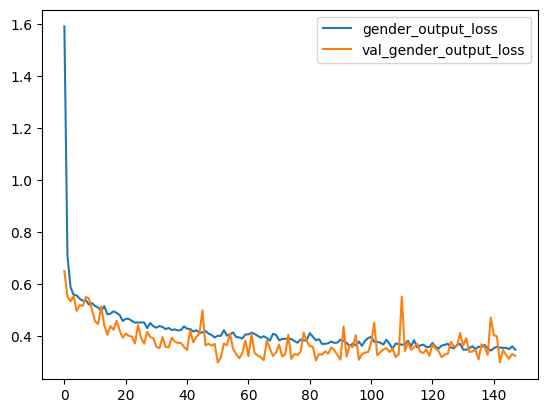

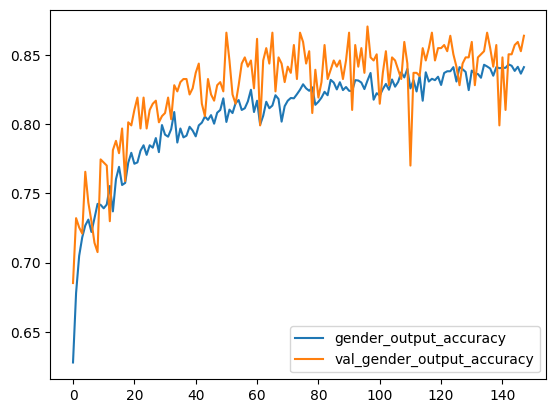

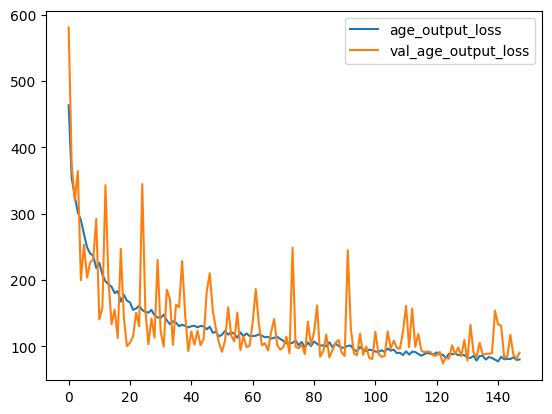

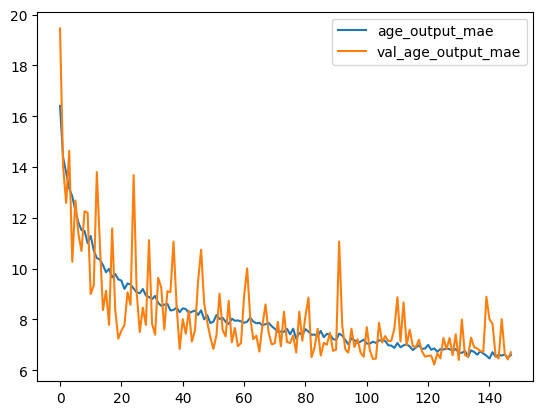

In [11]:
#
# Add your code here
#
model_history_df = pd.DataFrame(model_history.history)
model_history_df.loc[:, ['gender_output_loss', 'val_gender_output_loss']].plot()
print("Minimum Validation Loss for Gender: {:0.4f}".format(model_history_df['val_gender_output_loss'].min()))
model_history_df.loc[:, ['gender_output_accuracy', 'val_gender_output_accuracy']].plot()
print("Maximum Validation Accuracy: {:0.4f}".format(model_history_df['val_gender_output_accuracy'].max()))
model_history_df.loc[:, ['age_output_loss', 'val_age_output_loss']].plot()
print("Minimum Validation loss for Age: {:0.4f}".format(model_history_df['val_age_output_loss'].min()))
model_history_df.loc[:, ['age_output_mae', 'val_age_output_mae']].plot()
print("Minimum Validation MAE: {:0.4f}".format(model_history_df['val_age_output_mae'].min()))

#plt.plot(model_history.history['gender_output_loss'],model_history.history['val_gender_output_loss'],color='yellow')
#plt.plot(model_history.history['gender_'],color='red')
#plt.plot(model_history.history['age_output_loss'],color='blue')
#plt.ylim(-1,1)

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, 4, 4, 512)            1471468   ['input_12[0][0]']            
                                                          8                                       
                                                                                                  
 global_max_pooling2d_5 (Gl  (None, 512)                  0         ['vgg16[0][0]']               
 obalMaxPooling2D)                                                                                
                                                                                            

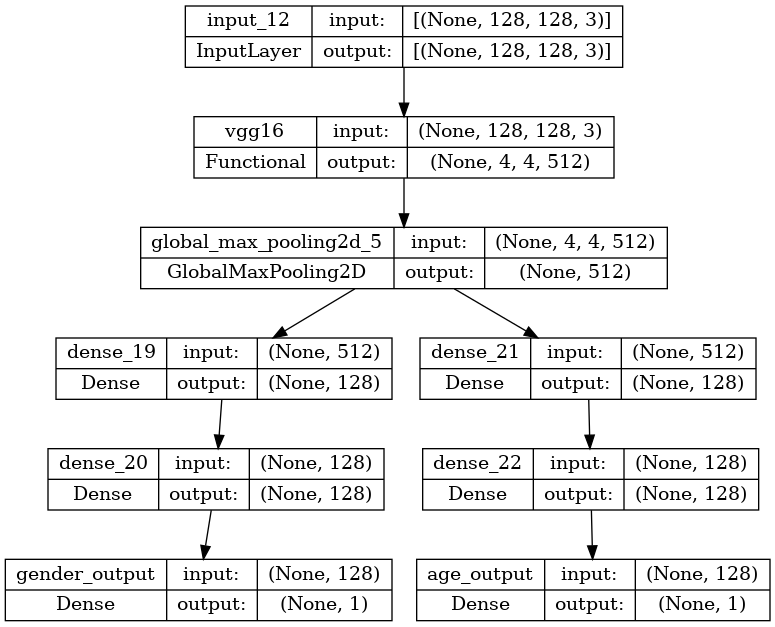

In [30]:
#
# Add your code here
#
from keras.applications import VGG16
from keras.models import Model
from keras.regularizers import l2

early_stopping=EarlyStopping(
    #min_delta=0.001,
    patience=25,
    monitor='val_loss',
    restore_best_weights=True,
)
model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
#model.trainable=False
# Use the model as a single layer
new_input = layers.Input(shape=(128, 128, 3))
for layer in model.layers[:-2]:
    layer.trainable = False
output = model(new_input)

x = GlobalMaxPooling2D()(output)
# x = Dropout(0.4)(x)
# x = Dense(256, activation='relu')(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.4)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.4)(x)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)

gender_branch = Dense(128, activation='relu')(x)
gender_branch = Dense(128, activation='relu')(gender_branch)
#gender_branch = Dropout(0.4)(gender_branch)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

age_branch = Dense(128, activation='relu')(x)
age_branch = Dense(128, activation='relu')(age_branch)
#age_branch = Dropout(0.4)(age_branch)
age_output = Dense(1, activation='linear', name='age_output')(age_branch)

# Create a new model with the Xception model as a single layer
modelB = Model(inputs=new_input, outputs=[gender_output, age_output])


modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [31]:
#
# Add your code here
#
from keras.optimizers import Adam

modelB.compile(loss={'gender_output':'binary_crossentropy','age_output':'mse'}, optimizer=Adam(learning_rate=0.001),metrics={'gender_output':'accuracy','age_output':'mae'})

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size

model_history = modelB.fit(train_generator, 
                           steps_per_epoch=STEP_SIZE_TRAIN, 
                           epochs=200,
                           validation_data=val_generator,
                           validation_steps=STEP_SIZE_VALID,
                           callbacks=[early_stopping])

modelB.save("/mnt/c/Users/Rwitobaan/Desktop/code/ML/"+"age_gender_B.h5")

Epoch 1/200
562/562 [==============================] - 21s 35ms/step - loss: 221.9560 - gender_output_loss: 0.6536 - age_output_loss: 221.3024 - gender_output_accuracy: 0.6340 - age_output_mae: 11.2540 - val_loss: 143.8491 - val_gender_output_loss: 0.5801 - val_age_output_loss: 143.2690 - val_gender_output_accuracy: 0.7016 - val_age_output_mae: 9.3516
Epoch 2/200
562/562 [==============================] - 18s 32ms/step - loss: 147.5239 - gender_output_loss: 0.5837 - age_output_loss: 146.9401 - gender_output_accuracy: 0.6952 - age_output_mae: 9.0215 - val_loss: 112.5051 - val_gender_output_loss: 0.5466 - val_age_output_loss: 111.9585 - val_gender_output_accuracy: 0.7379 - val_age_output_mae: 7.6439
Epoch 3/200
562/562 [==============================] - 17s 30ms/step - loss: 135.6154 - gender_output_loss: 0.5620 - age_output_loss: 135.0535 - gender_output_accuracy: 0.7075 - age_output_mae: 8.5468 - val_loss: 105.2435 - val_gender_output_loss: 0.5192 - val_age_output_loss: 104.7243 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
modelB.evaluate(x=x_test,y=y_test)

16/16 [==============================] - 1s 33ms/step - loss: 87.6421 - gender_output_loss: 0.3575 - age_output_loss: 87.2846 - gender_output_accuracy: 0.8480 - age_output_mae: 6.6103


[87.64207458496094,
 0.3574650287628174,
 87.28461456298828,
 0.8479999899864197,
 6.610267639160156]

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

Minimum Validation Loss for Gender: 0.3597


Maximum Validation Accuracy: 0.8669
Minimum Validation loss for Age: 87.3513
Minimum Validation MAE: 6.5372


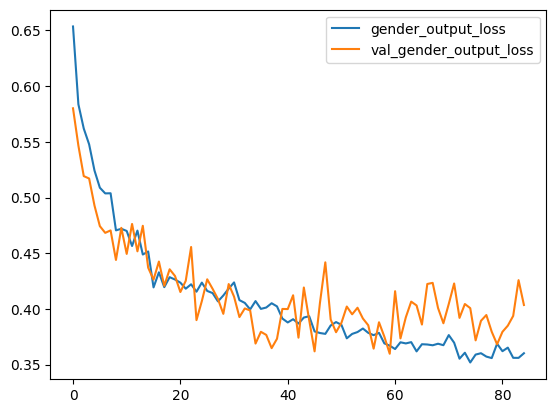

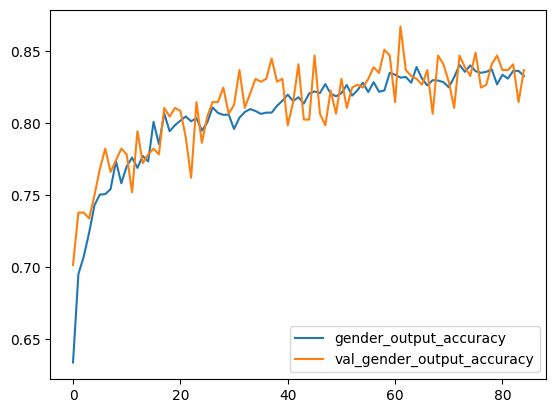

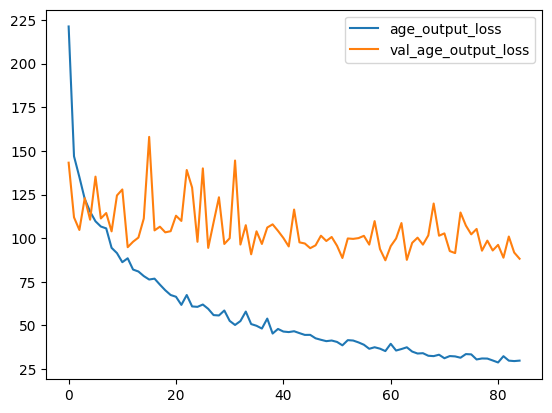

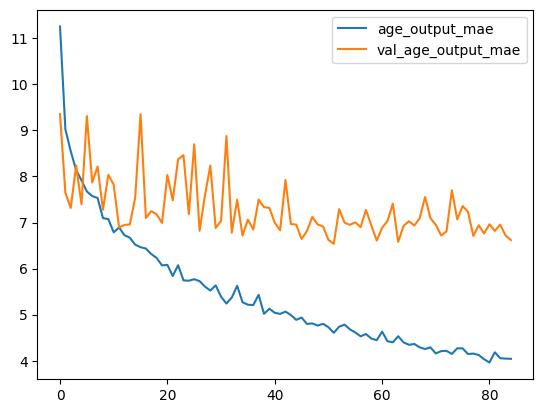

In [33]:
#
# Add your code here
#
model_history_df = pd.DataFrame(model_history.history)
model_history_df.loc[:, ['gender_output_loss', 'val_gender_output_loss']].plot()
print("Minimum Validation Loss for Gender: {:0.4f}".format(model_history_df['val_gender_output_loss'].min()))
model_history_df.loc[:, ['gender_output_accuracy', 'val_gender_output_accuracy']].plot()
print("Maximum Validation Accuracy: {:0.4f}".format(model_history_df['val_gender_output_accuracy'].max()))
model_history_df.loc[:, ['age_output_loss', 'val_age_output_loss']].plot()
print("Minimum Validation loss for Age: {:0.4f}".format(model_history_df['val_age_output_loss'].min()))
model_history_df.loc[:, ['age_output_mae', 'val_age_output_mae']].plot()
print("Minimum Validation MAE: {:0.4f}".format(model_history_df['val_age_output_mae'].min()))

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#